# Power and false positives

Peter Ralph

https://uodsci.github.io/dsci345

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import pandas as pd
import numpy as np
import scipy.stats

rng = np.random.default_rng(seed=123)

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}}$$
This is here so we can use `\P` and `\E` and `\var` and `\sd` in LaTeX below.

# Power analysis

Suppose we're measuring expression
of many ($\sim$ 1,000) genes
in a bunch of organisms at night and during the day.
We'd like to know which genes are expressed 
at different levels in night and day, and by how much.

However, gene expression is highly variable: some genes
differ much more between individuals than others.
Here's a model for $X$, the difference in log gene expression
of a random gene in a random individual:
$$ \begin{aligned}
    \text{mean difference:} \qquad M &\sim \begin{cases} 3 \qquad &\text{with probability}\; 1/2 \\ 0 \qquad &\text{with probability}\; 1/2 \end{cases} \\
    \text{SD difference:} \qquad D &\sim \text{Exponential}(\text{mean}=2) \\
    \text{measured difference:} \qquad X &\sim \text{Normal}(\text{mean}=M, \text{sd}=D) .
\end{aligned}$$

*Goals:* We will want to, in the real data,

- Identify genes that we're sure are differentially expressed.
- Estimate how different their expression levels are.

So, let's simulate from this and test out our methods.

## Simulate


*(Question: what shapes will M, D, and X be?)*

In [2]:
num_samples = 12
num_genes = 1000
M = rng.choice([0, 3], size=num_genes)
D = rng.exponential(scale=2, size=num_genes)
X = np.empty((num_genes, num_samples))
for g in range(num_genes):
    X[g, :] = rng.normal(loc=M[g], scale=D[g], size=num_samples)
# X = rng.normal(loc=M[:,np.newaxis], scale=D[:,np.newaxis], size=(num_genes, num_samples))

## Methods

How will we identify differentially expressed genes?
For each gene, let's 
1. do a $t$-test, and 
2. Then, we'll take the genes with $p$-value below $\alpha$ as candidate differentially expressed genes.
    What proportion do we get right (**power**) and wrong (**false positive rate**),
    and how does this depend on $D$?
3. Finally, find a 95% confidence interval.

First, the $t$-tests.
How do we use `scipy.stats.ttest_1samp()`? What shapes will the results be?

In [3]:
X[0,:]

array([-0.85499429,  1.95194657,  1.574154  , -1.50612842, -3.19241088,
       -2.93603326,  6.5657543 ,  1.2781657 ,  3.55481994,  3.17887591,
        0.36845035,  1.32957611])

In [4]:
scipy.stats.ttest_1samp(X[0,:], popmean=0)

TtestResult(statistic=np.float64(1.162337727509018), pvalue=np.float64(0.2696961317089917), df=np.int64(11))

In [5]:
ttests = scipy.stats.ttest_1samp(X.T, popmean=0)

In [6]:
ttests.pvalue.shape

(1000,)

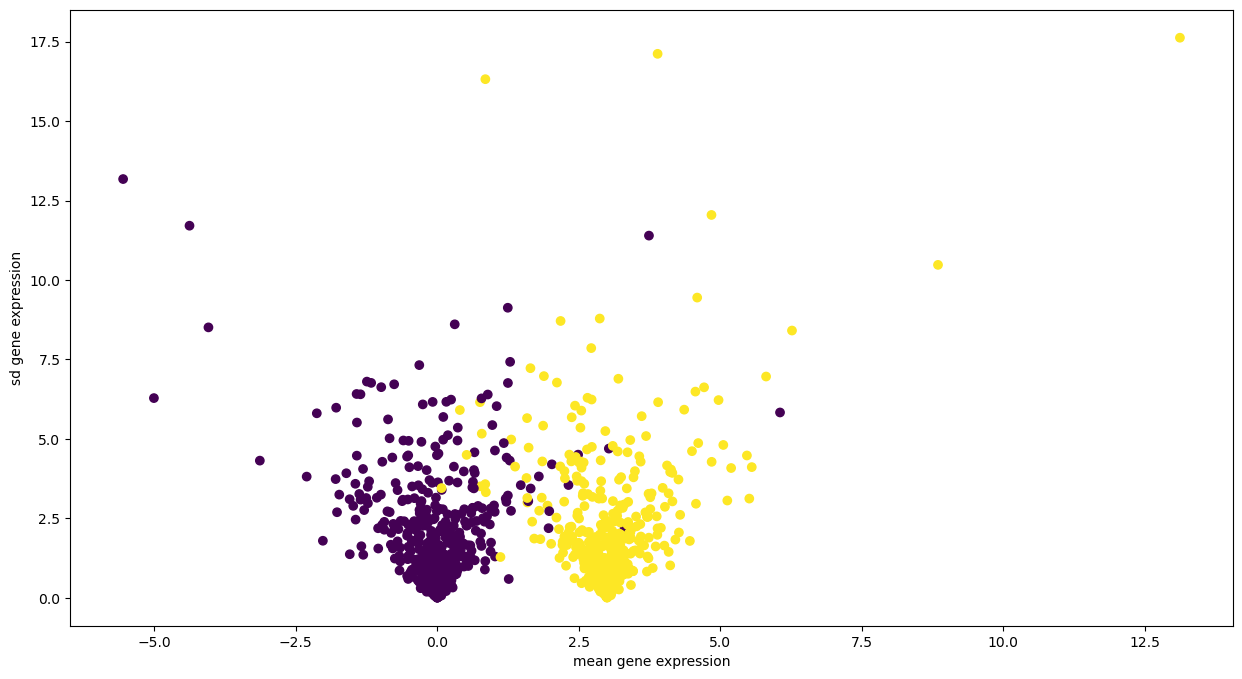

In [7]:
fig, ax = plt.subplots()

X_means = np.mean(X, axis=1)
X_sd = np.std(X, ddof=1, axis=1)
ax.scatter(X_means, X_sd, c=M)
ax.set_xlabel("mean gene expression")
ax.set_ylabel("sd gene expression");

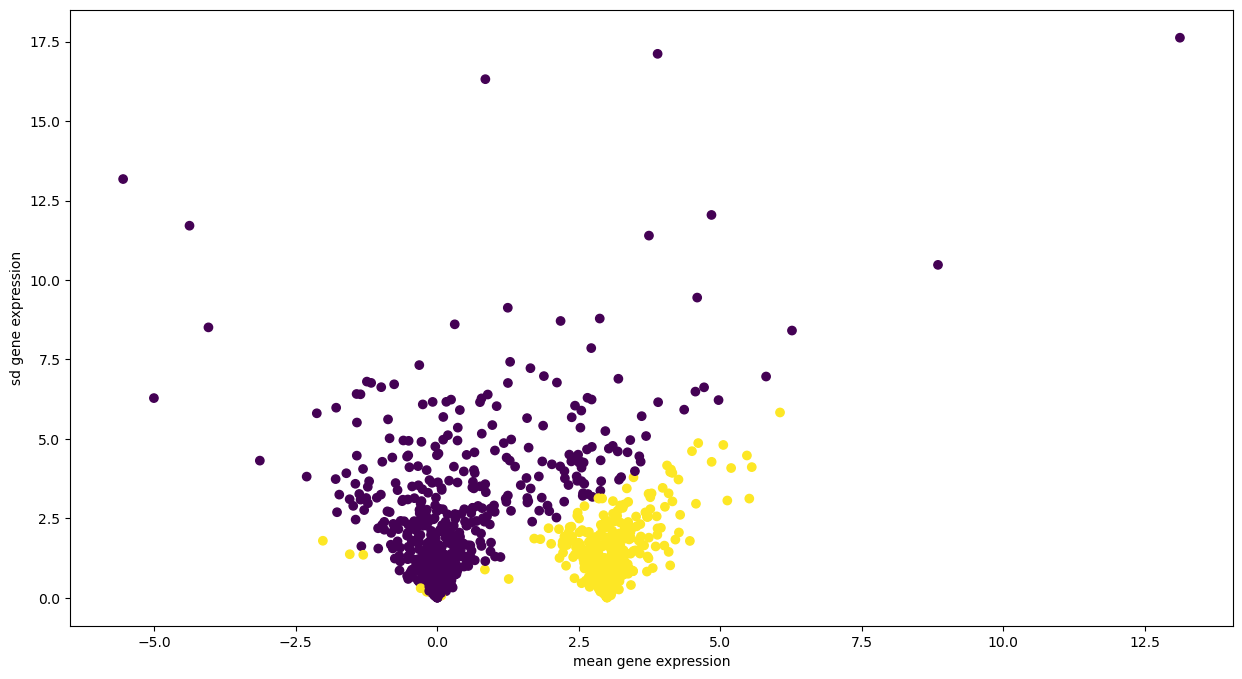

In [8]:
fig, ax = plt.subplots()

X_means = np.mean(X, axis=1)
X_sd = np.std(X, ddof=1, axis=1)
ax.scatter(X_means, X_sd, c=ttests.pvalue < 0.01)
ax.set_xlabel("mean gene expression")
ax.set_ylabel("sd gene expression");

Overall performance: How do we find how many *true positives* we have? False positives? True/false negatives?

The true positives are genes for which $M>0$ (i.e., there is actually a difference
between night & day) *and* for which the $p$-value is less than $\alpha$
(which btw we have to pick).
Going (arbitrarily) with $\alpha=0.01$, this is:

In [9]:
alpha = 0.01
pvalues = ttests.pvalue
true_pos = np.logical_and(M > 0, pvalues < alpha) 
num_true_pos = np.sum(true_pos)
num_true_pos, np.sum(M > 0), num_true_pos / np.sum(M > 0)

(np.int64(392), np.int64(477), np.float64(0.8218029350104822))

So -our power (probability of detecting a difference when there is one)
is 392/477 = 82\%.

Similarly, our false positive rate is:

In [10]:
num_false_neg = np.sum(np.logical_and(M > 0, pvalues >= alpha))
num_false_pos = np.sum(np.logical_and(M == 0, pvalues < alpha))
num_true_neg = np.sum(np.logical_and(M == 0, pvalues >= alpha))
print(
    f"False positive: {num_false_pos/np.sum(M==0)}\n"
    f"False negative (1 - power): {num_false_neg/np.sum(M>0)}\n "
    f"True negative (1 - false positive): {num_true_neg/np.sum(M==0)}"
)

False positive: 0.021032504780114723
False negative (1 - power): 0.17819706498951782
 True negative (1 - false positive): 0.9789674952198852


**Question:** How can we summarise power and false positive rate as a function of $D$?

Well, let's just do the calculations above but binning by values of $D$.

In [11]:
dbreaks = np.array([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, np.inf])
nbins = len(dbreaks) - 1
dbin = np.searchsorted(dbreaks, D) - 1
dmeans = np.empty(nbins)
num_genes = np.empty(nbins, dtype=int)
num_no_effect = np.empty(nbins, dtype=int)
num_small_p = np.empty(nbins, dtype=int)
power = np.empty(nbins)
false_pos = np.empty(nbins)
for k in range(nbins):
    this_bin = (dbin == k)
    dmeans[k] = np.mean(D[this_bin])
    num_genes[k] = np.sum(this_bin)
    num_no_effect[k] = np.sum(M[this_bin] == 0)
    num_small_p[k] = np.sum(pvalues[this_bin] < alpha)
    power[k] = np.sum(
        np.logical_and(M[this_bin] > 0,
                       pvalues[this_bin] < alpha)) / (num_genes[k] - num_no_effect[k])
    false_pos[k] = np.sum(
        np.logical_and(M[this_bin] == 0,
                       pvalues[this_bin] < alpha)) / num_no_effect[k]

In [12]:
for k, (ng, m, nn, ns, p, fp) in enumerate(zip(num_genes, dmeans, num_no_effect, num_small_p, power, false_pos)):
    print(f"Bin from {dbreaks[k]} to {dbreaks[k+1]}: "
          f"(mean(D): {m:.1f})\n\t"
          f"{ng} genes; "
          f"{nn} with M=0; "
          f"power: {100*p:.0f}%; "
          f"false pos rate: {100*fp:.0f}%; "
    )

Bin from 0.0 to 0.5: (mean(D): 0.2)
	225 genes; 123 with M=0; power: 100%; false pos rate: 2%; 
Bin from 0.5 to 1.0: (mean(D): 0.7)
	162 genes; 80 with M=0; power: 100%; false pos rate: 0%; 
Bin from 1.0 to 1.5: (mean(D): 1.2)
	126 genes; 63 with M=0; power: 100%; false pos rate: 2%; 
Bin from 1.5 to 2.0: (mean(D): 1.7)
	116 genes; 62 with M=0; power: 100%; false pos rate: 3%; 
Bin from 2.0 to 2.5: (mean(D): 2.2)
	75 genes; 43 with M=0; power: 100%; false pos rate: 2%; 
Bin from 2.5 to 3.0: (mean(D): 2.7)
	76 genes; 38 with M=0; power: 76%; false pos rate: 3%; 
Bin from 3.0 to 3.5: (mean(D): 3.2)
	53 genes; 29 with M=0; power: 58%; false pos rate: 3%; 
Bin from 3.5 to 4.0: (mean(D): 3.8)
	41 genes; 25 with M=0; power: 25%; false pos rate: 0%; 
Bin from 4.0 to inf: (mean(D): 5.9)
	126 genes; 60 with M=0; power: 18%; false pos rate: 3%; 


Here's a plot of that data:

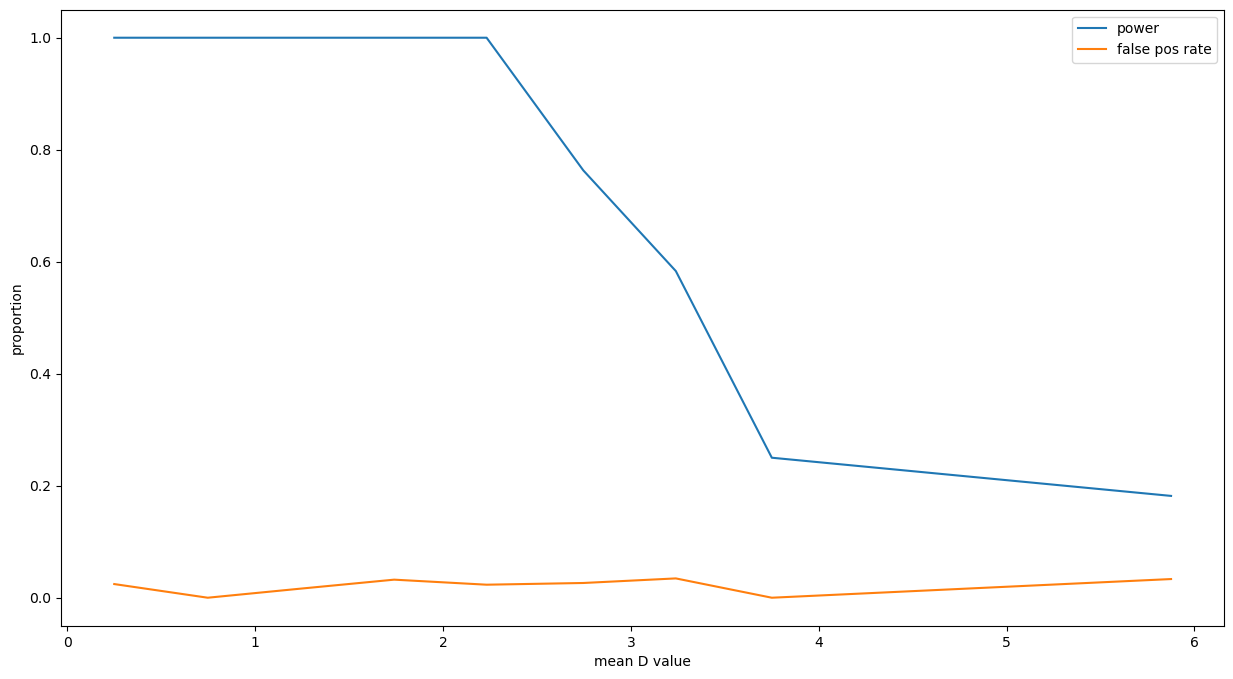

In [13]:
fig, ax = plt.subplots()
ax.plot(dmeans, power, label='power')
ax.plot(dmeans, false_pos, label='false pos rate')
ax.legend()
ax.set_xlabel("mean D value")
ax.set_ylabel("proportion");

*Exercise:* How can we check whether confidence intervals are *well-calibrated* (i.e., behave as advertised)?